# Computational control - Tutorial 8: Data -driven predictive control

This week we will implement the Data-enabled Predictive Control (DeePC) algorithm on a double integrator system.

### Package imports

In [8]:
import numpy as np                         # For linear algebra
import cvxpy as cp                         # For convex optimization
import matplotlib.pyplot as plt            # For plots
np.random.seed(1)                          # Generate random seed
np.set_printoptions(precision=1)           # Set nice printing format

#### Double Integrator System

In [29]:
dt = .1
mass = 1

A = np.array([[1, dt],
              [0, 1]])
B = np.array([[(dt/mass)**2/2],
              [dt/mass]])
C = np.array([[1, 0]])

# System constants
n = np.shape(A)[0]
m = np.shape(B)[1]
p = np.shape(C)[0]

**Investigate Hankel Rank**

T_past is the number of timesteps into the past that the DeePC optimization considers.

T_fut is the number of timesteps into the future that the DeePC optimization plans for.

L = T_past + T_fut

T is the total number of timesteps used to build the Hankel matrix

**Question**

What rank do we expect for the rank of the input-and-output Hankel matrix (np.vstack((H_u,H_y))) with L = 12 and T = 30?

**Answer**:
After L+n = 14

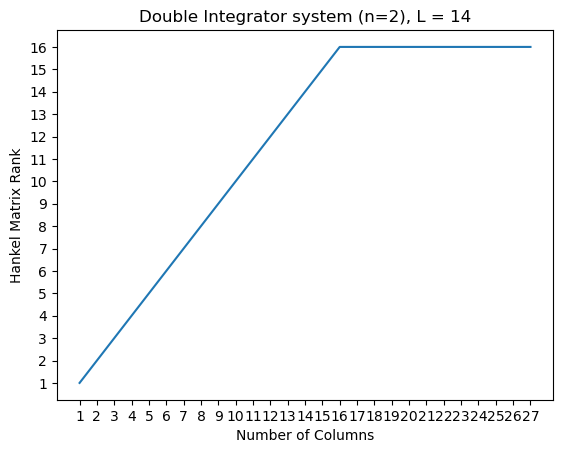

Shape of the Hankel matrix: (14, 27)
Shape of the Hankel matrix: (14, 27)


In [86]:
# Set Hankel dimensions
T_past = 6
T_fut = 8
L = T_past+T_fut

# T is the total number of data points used to build the Hankel matrix
T = 40

# Collect data
x_data = np.zeros((T+1,2))
u_data = np.zeros((T,1))
y_data = np.zeros((T,1))
for i in range(T):
    u_data[i] = np.random.randn(1)
    x_data[i+1] = A@x_data[i] + B@u_data[i]
    y_data[i] = C@x_data[i]

# Initialize
num_hankel_cols = T-L+1
rank_hankel = [1]
H_u = u_data[:L]
H_y = y_data[:L]

# Construct Hankel matrix
for i in range(1,num_hankel_cols):
    H_u = np.hstack((H_u,u_data[i:i+L]))
    H_y = np.hstack((H_y,y_data[i:i+L]))
    rank_hankel.append(np.linalg.matrix_rank(np.vstack((H_u,H_y))))

# Plot rank
plt.plot(range(num_hankel_cols), rank_hankel)
plt.xlabel('Number of Columns')
plt.ylabel('Hankel Matrix Rank')
plt.title(f'Double Integrator system (n=2), L = {L}')
plt.xticks(range(num_hankel_cols), [i+1 for i in range(num_hankel_cols)])
plt.yticks(range(1,m*L+n+1))
plt.show()

print(f'Shape of the Hankel matrix: {np.shape(H_u)}')
print(f'Shape of the Hankel matrix: {np.shape(H_y)}')

**Question**

What is the maximum rank of the Hankel matrix?

**Answer**:
14 Here, generally L + n (SISO), mL + n (MIMO)

**Question**

For L = 12 and T = 30, we saw the Hankel matrix has 19 columns. What is a general formula for the number of columns of the Hankel matrix in terms of L and T?

**Answer**:
T - L + 1

**Build the DeePC controller**

In [87]:
# DeePC controller hyperparameters
r = 0.0001 # this is input cost weight in the DeePC optimization
# T_past = 2 # set above, when we built the Hankel matrix
# T_fut = 10 # set above, when we built the Hankel matrix
# T = 30 # set above, when we built the Hankel matrix

**Build the DeePC Controller**

In [88]:
class DeePCcontrollerClass:
    def __init__(self, T, T_past, T_fut, m, p, r, H_u, H_y):

        self.T = T
        self.T_past = T_past
        self.T_fut = T_fut

        self.m = m
        self.p = p
        self.r = r

        self.H_u = H_u
        self.H_y = H_y


    def step(self, u_past, y_past, y_ref):
        """
        Returns the first T_fut actions of input sequence.
        """
        verbose=False

        ########################################################################
        ########################## Your code from here #########################
        ########################################################################

        # Set up the DeePC optimization in CVX
        # Helpful CVX functions: cp.Variable(), cp.quad_form()

        # Variable
        y = cp.Variable(self.p*self.T_fut)
        u = cp.Variable(self.m*self.T_fut)
        g = cp.Variable(self.T-self.T_past-self.T_fut + 1)

        # Cost
        cost = cp.quad_form(y-y_ref,np.eye(self.T_fut)) + self.r * cp.quad_form(u,np.eye(self.T_fut))

        # Partioning
        U_p = self.H_u[:self.m*self.T_past]
        U_f = self.H_u[-self.m*self.T_fut:]
        Y_p = self.H_y[:self.p * self.T_past]
        Y_f = self.H_y[-self.p * self.T_fut:]

        # Constraints
        constraints = [
            U_p @ g == u_past,
            U_f @ g == u,
            Y_p @ g == y_past,
            Y_f @ g == y
        ]

        ########################################################################
        ################################ To here ###############################
        ########################################################################

        prob = cp.Problem(cp.Minimize(cost), constraints)
        prob.solve(verbose=False)

        if prob.status != 'optimal':
            raise Exception(f'cvx had an issue with the optimization. Got prob.status: {prob.status}')

        u_fut = u.value
        return u_fut

# Instantiate DeePCcontrollerClass
DeePCcontroller = DeePCcontrollerClass(T, T_past, T_fut, m, p, r, H_u, H_y)

**DeePC evaluation simulation**

In [89]:
# DeePC evaluation simulation settings

T_sim = 20 #simulation time steps
y_reference = 1

u_sim = np.zeros((T_sim, m))
x_sim = np.zeros((T_sim+1, n))
y_sim = np.zeros((T_sim, p))
y_reference_sim = np.ones((T_sim, p*T_fut))*y_reference

#Initial states set to 0
x_sim[0] = np.zeros(n)
u_past_sim = np.zeros(m*T_past)
y_past_sim = np.zeros(p*T_past)

for i in range(T_sim):
      ########################################################################
      ########################## Your code from here #########################
      ########################################################################

      # Get the control action using DeePCcontroller.step()  
      u_fut = DeePCcontroller.step(u_past_sim, y_past_sim, y_reference_sim[i])
      u_sim[i] = u_fut[:m]


      ########################################################################
      ################################ To here ###############################
      ########################################################################

      x_sim[i+1] = A@x_sim[i] + B@u_sim[i]
      y_sim[i] = C@x_sim[i]

      # Update u_past_sim and y_past_sim

      u_past_sim = np.append(u_past_sim[m:], u_sim[i])
      y_past_sim = np.append(y_past_sim[m:], y_sim[i])

print('Simulation complete')

Simulation complete


Plot the trajectory created by the DeePC controller in closed loop with the double integrator.

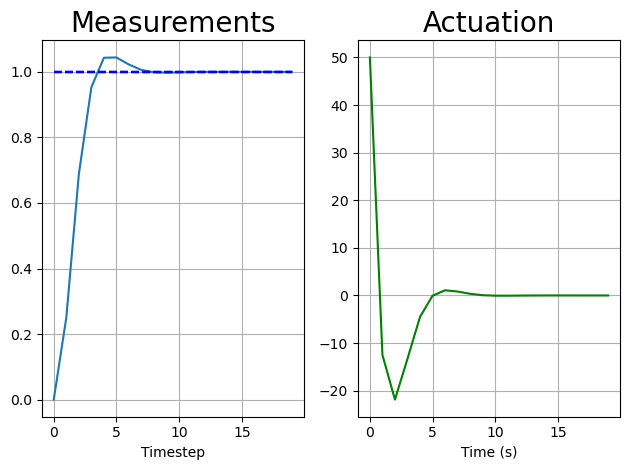

In [90]:
## Plot results

plt.subplot(1,2,1)
plt.plot(range(0,T_sim), y_sim)
plt.plot(range(0,T_sim), y_reference_sim, 'b--')
plt.xlabel('Timestep')
plt.title("Measurements", fontdict={'fontsize':20})
plt.grid('on')
plt.tight_layout()

plt.subplot(1,2,2)
plt.plot(range(0,T_sim), u_sim, 'g')
plt.xlabel('Time (s)')
plt.title("Actuation", fontdict={'fontsize':20})
plt.grid('on')
plt.tight_layout()

plt.show()

**WARNING**

DeePC in sensitive to hyperparameters (T, T_past, T_fut, r, etc.)

### Bonus questions

<!-- Question -->

**Question**

What is the minimum number of timesteps needed to build a Hankel matrix with this rank?

<!-- Answer -->

**Answer**:

14

<!-- Question -->

**Question**

What happens if you use a longer data set?

<!-- Answer -->

**Answer**:

There is no advantage, as you are just adding linearly dependent columns. Nothing happens. 

<!-- Question -->

**Question**

What is the minimum T_past that you need to capture the underlying state of the system at time $t$?

<!-- Answer -->

**Answer**:

For SISO systems: l=n --> Here 2
<!-- Question -->

**Question**

What is an approriate T_fut?

<!-- Answer -->

**Answer**:

The smallest numer, so that the rank is still maximised. Here: 
<!-- Question -->

**Question**: Adjust the hyperparameters for the double integrator system.  What is the behavior you observe?

<!-- Answer -->

**Answer**:

T_fut = 1 just fails. 
T_fut = 2 oscillations
T_fut e [5, 15] yields resonable results
T_fut= 20 osciallations with ss error

T_past > 2 does not help. 

T small just fails